# GA DSI 26: Project 3 - Reddit Subreddits Classification
***

## Notebook organisation
- Notebook 1: Introduction, Web scraping and Data Acquisition
- **Notebook 2: EDA and Pre-Processing (current notebook)**
- Notebook 3: Model Preparation, Tuning, Insights and Conclusion
 ***
 
In this notebook, I will be carrying out data cleaning, EDA and pre-processing of the data that was scraped from the r/buildapc and r/techsupport subreddit in preparation for modeling. 

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')


from wordcloud import WordCloud
from matplotlib_venn import venn2
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings("ignore")

## Import data from Notebook 1
***


In [2]:
# import the data
buildapc = pd.read_csv('../datasets/buildapc.csv')
techsupport = pd.read_csv('../datasets/techsupport.csv')

In [3]:
# Visualise the data
print(buildapc.shape)
print(buildapc.info())
buildapc.head()

(976, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 976 entries, 0 to 975
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  976 non-null    object
 1   title      976 non-null    object
 2   selftext   946 non-null    object
dtypes: object(3)
memory usage: 23.0+ KB
None


,subreddit,title,selftext
0,buildapc,3080 or 6900xt?,So I'm gonna be building a gaming PC for 4k ga...
1,buildapc,"Upgrading to a 1440p144Hz setup, would like so...",**What is your intended use for this build? Th...
2,buildapc,Help fine tune my build before it's final.,My 2500k/980 build is on it's knees and about ...
3,buildapc,Need help picking out a KVM or other solution ...,"As the tittle says, im looking for a KVM switc..."
4,buildapc,Ryzen 5 3600 + GT 710 or Ryzen 3 3200G,Hello! So unfortunately my old GPU died last w...


There are some null values in the `'selftext'` column as those are the posts with a valid title but no selftext hence these rows are sliced out before removing duplicates and then the rows are concatenated back into the dataframe. 

In [4]:
# Visualise the data
print(techsupport.shape)
print(techsupport.info())
techsupport.head()

(933, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 933 entries, 0 to 932
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  933 non-null    object
 1   title      933 non-null    object
 2   selftext   933 non-null    object
dtypes: object(3)
memory usage: 22.0+ KB
None


,subreddit,title,selftext
0,techsupport,Win 11 dwm.exe is using way too much vram,"I have been on Win 11 since the beta, in Octob..."
1,techsupport,Toshiba Qosmio X70B10T graphics card not detec...,I recently had this laptop formated and I just...
2,techsupport,How to find original MD5 Hash,"Hello, I am trying to determine if a file I ha..."
3,techsupport,Is it worth upgrading to Windows 11 for mostly...,I recently got the notif that I can upgrade to...
4,techsupport,"Deleted google tv remote, can't control tv",I was having trouble with my chromecast google...


A total of 976 posts and 933 posts were scraped from r/buildapc and r/techsupport respectively. These posts were scraped on 13th January 2022. 

Recall that the objective is the company wants to build a classification model to sort and classify future incoming requests into the two categories of PC building queries or after-sales support. The columns saved from the scrapped data in the dataframes which are imported into this notebook are `'subreddit'`, `'title'` and `'selftext'` as these are the information needed to create a classification model to classify incoming requests for my company. 

## Feature Engineering
***

Before starting EDA, I will be creating a new column to combine the `'title'` and `'selftext'` columns into a single columns for EDA. 

### Creating new column `'text'`

In [5]:
# fill the null values in the 'selftext' column with an empty string
buildapc['selftext'].fillna('', inplace = True)

In [6]:
# Creating a new column 'text'
buildapc['text'] = buildapc['title'] + ' ' + buildapc['selftext']
buildapc.head()

,subreddit,title,selftext,text
0,buildapc,3080 or 6900xt?,So I'm gonna be building a gaming PC for 4k ga...,3080 or 6900xt? So I'm gonna be building a gam...
1,buildapc,"Upgrading to a 1440p144Hz setup, would like so...",**What is your intended use for this build? Th...,"Upgrading to a 1440p144Hz setup, would like so..."
2,buildapc,Help fine tune my build before it's final.,My 2500k/980 build is on it's knees and about ...,Help fine tune my build before it's final. My ...
3,buildapc,Need help picking out a KVM or other solution ...,"As the tittle says, im looking for a KVM switc...",Need help picking out a KVM or other solution ...
4,buildapc,Ryzen 5 3600 + GT 710 or Ryzen 3 3200G,Hello! So unfortunately my old GPU died last w...,Ryzen 5 3600 + GT 710 or Ryzen 3 3200G Hello! ...


In [7]:
techsupport['text'] = techsupport['title'] + ' ' + techsupport['selftext']
techsupport.head()

,subreddit,title,selftext,text
0,techsupport,Win 11 dwm.exe is using way too much vram,"I have been on Win 11 since the beta, in Octob...",Win 11 dwm.exe is using way too much vram I ha...
1,techsupport,Toshiba Qosmio X70B10T graphics card not detec...,I recently had this laptop formated and I just...,Toshiba Qosmio X70B10T graphics card not detec...
2,techsupport,How to find original MD5 Hash,"Hello, I am trying to determine if a file I ha...","How to find original MD5 Hash Hello, I am tryi..."
3,techsupport,Is it worth upgrading to Windows 11 for mostly...,I recently got the notif that I can upgrade to...,Is it worth upgrading to Windows 11 for mostly...
4,techsupport,"Deleted google tv remote, can't control tv",I was having trouble with my chromecast google...,"Deleted google tv remote, can't control tv I w..."


## Preliminary EDA for subreddit text

### Using `CountVectorizer`

To do EDA for text, we will need to convert text data into a structured, numeric dataframe and for this purpose, I will be using CountVectorizer. 

In [8]:
# instantiate CountVectorizer
cvec = CountVectorizer(stop_words = 'english', ngram_range = (2,3))

I will be using bigrams, trigrams in my CountVectorizer for EDA in hopes to get more context of the words that people are using in their posts in both subreddits. 

#### Finding the top 50 words by count in both subreddits

In [9]:
# get the top 50 words for r/buildapc subreddit
cvec_buildapc = cvec.fit_transform(buildapc['text'])
cvec_buildapc = pd.DataFrame(cvec_buildapc.toarray(), columns = cvec.get_feature_names())
buildapc_text_50 = cvec_buildapc.sum().sort_values(ascending = False).head(50)

In [10]:
# get the top 50 words for r/techsupport subreddit
cvec_techsupport = cvec.fit_transform(techsupport['text'])
cvec_techsupport = pd.DataFrame(cvec_techsupport.toarray(), columns = cvec.get_feature_names())
techsupport_text_50 = cvec_techsupport.sum().sort_values(ascending = False).head(50)

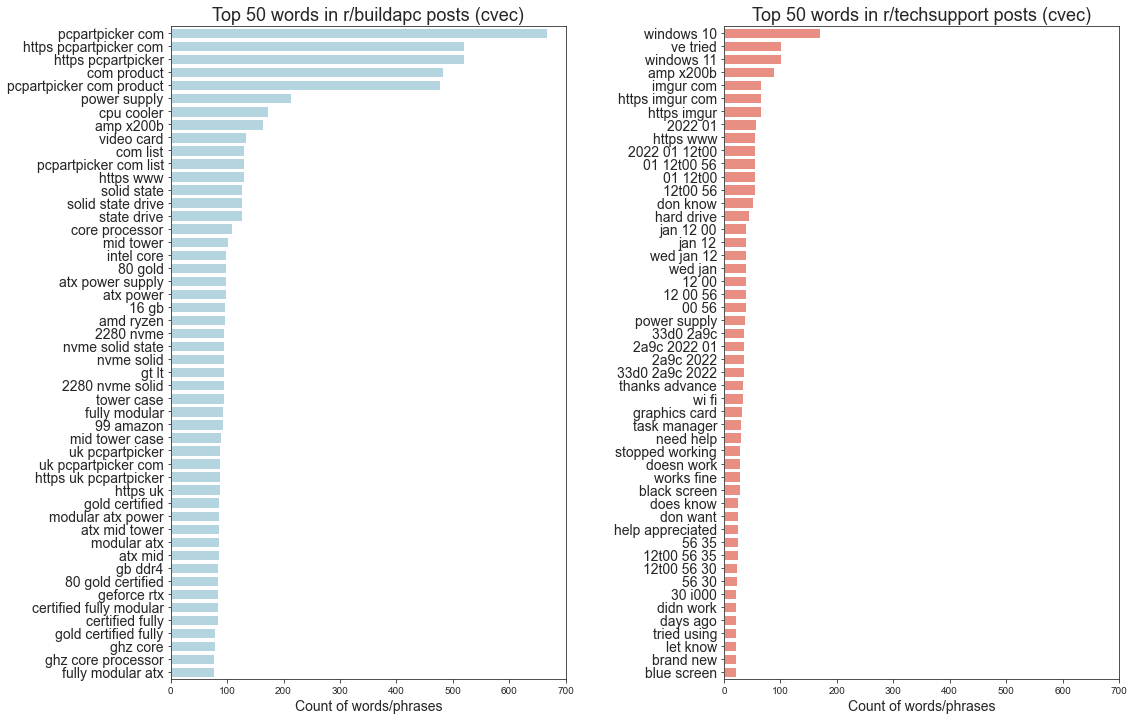

In [11]:
# plot bar charts of top 50 words in the text of posts of both subreddits
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (17,12), sharex = True)
plt.subplots_adjust(wspace = 0.4)

# bar chart for r/buildapc
sns.barplot(y = buildapc_text_50.index.values, x = buildapc_text_50, ax = ax[0], color='lightblue')
ax[0].set_title('Top 50 words in r/buildapc posts (cvec)', fontsize = 18)
ax[0].set_xlabel('Count of words/phrases', fontsize = 14)
plt.setp(ax[0].get_yticklabels(), fontsize = 14)

# bar chart for r/techsupport
sns.barplot(y = techsupport_text_50.index.values, x = techsupport_text_50, ax = ax[1], color = 'salmon')
ax[1].set_title('Top 50 words in r/techsupport posts (cvec)', fontsize = 18)
ax[1].set_xlabel('Count of words/phrases', fontsize = 14)
plt.setp(ax[1].get_yticklabels(), fontsize = 14);

### Using `TfidfVectorizer`

In [12]:
# instantiate TfidfVectorizer
tf = TfidfVectorizer(stop_words = 'english', ngram_range = (2,3))

Similarly, I will be using bigrams, trigrams in my TfidfVectorizer for EDA in hopes to get more context of the words that people are using in their posts in both subreddits.

#### Finding the top 50 words in both subreddits

In [13]:
tf_buildapc = tf.fit_transform(buildapc['text'])
tf_buildapc = pd.DataFrame(tf_buildapc.toarray(), columns = tf.get_feature_names())
buildapc_text_50_tf = tf_buildapc.sum().sort_values(ascending = False).head(50)

In [14]:
tf_techsupport = tf.fit_transform(techsupport['text'])
tf_techsupport = pd.DataFrame(tf_techsupport.toarray(), columns = tf.get_feature_names())
techsupport_text_50_tf = tf_techsupport.sum().sort_values(ascending = False).head(50)

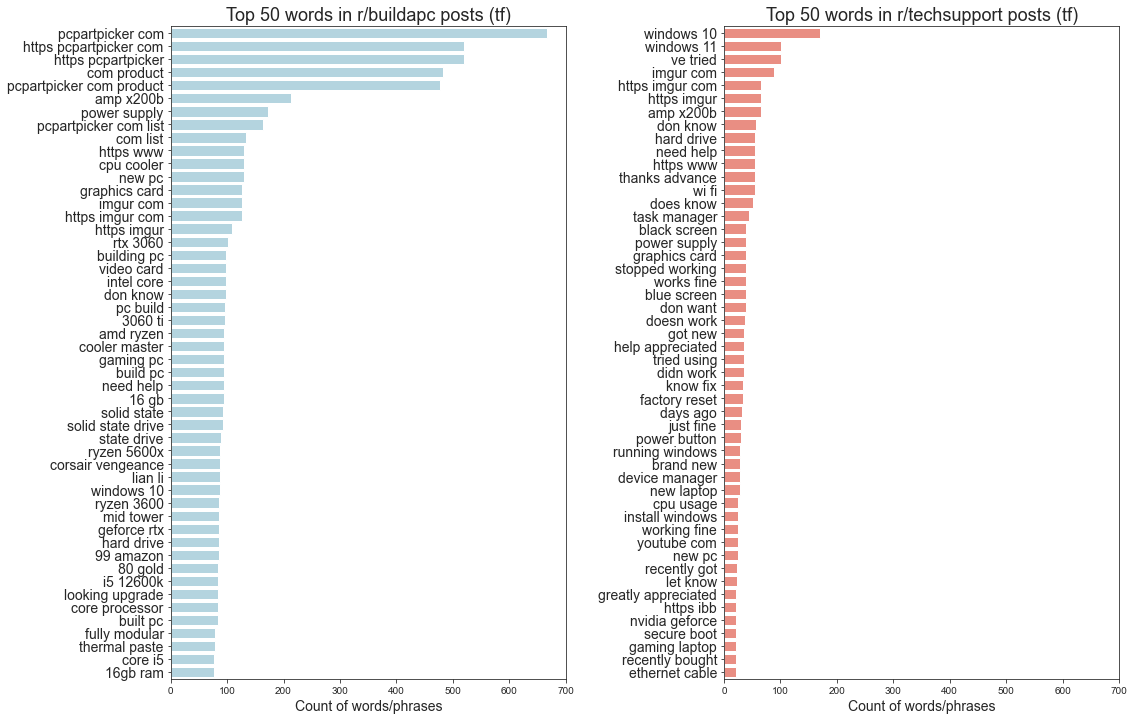

In [15]:
# plot bar charts of top 50 words in the text of posts of both subreddits
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (17,12), sharex = True)
plt.subplots_adjust(wspace = 0.4)

# bar chart for r/buildapc
sns.barplot(y = buildapc_text_50_tf.index.values, x = buildapc_text_50, ax = ax[0], color='lightblue')
ax[0].set_title('Top 50 words in r/buildapc posts (tf)', fontsize = 18)
ax[0].set_xlabel('Count of words/phrases', fontsize = 14)
plt.setp(ax[0].get_yticklabels(), fontsize = 14)

# bar chart for r/techsupport
sns.barplot(y = techsupport_text_50_tf.index.values, x = techsupport_text_50, ax = ax[1], color = 'salmon')
ax[1].set_title('Top 50 words in r/techsupport posts (tf)', fontsize = 18)
ax[1].set_xlabel('Count of words/phrases', fontsize = 14)
plt.setp(ax[1].get_yticklabels(), fontsize = 14);

### Observations from preliminary EDA

From the above bar charts obtained using the `CountVectorizer` and `TfidfVectorizer` with the default english stop words list to transform the word data and to extract bi-grams and tri-grams for preliminary visualisation, it can be seen that there are a lot of noise in the data. I will not be using mono-grams as the single words used can be very similar between the subreddits which could refer to computer parts brands, generic name of computer parts and operating system which is not useful for modeling as there are no context for the text. 

In the r/buildapc subreddit, the top occurring words in the posts are 'pcpartpicker com', 'https pcpartpicker com', 'https pcpartpicker' and in other arrangments. These are referring to the popular website [pcpartpicker](https://pcpartpicker.com/) where people can use to spec their PC parts for their build. The prevalence of these words would be likely due to people include the link to their pcpartpicker build list for others to reference when seeking advice on the subreddit. I will be removing all these words relating to the website link below. 

As for r/techsupport subreddit, the top occuring words in the posts are Windows 10 and Windows 11 which means that people are using this subreddit to seek support and guidelines for operating system related issues. However, there are also similar issues with words relating to weblinks like 'https imgur com', 'imgur com' and in other orders where these should be the links for screenshots of the issues that people are uploading with their posts. Another commonly occuring words are '2022 01 12t00', '2022 01' and '01 12t00 56' and after searching on the subreddit, it was because of a post where a poster uploaded the entire logs for their updater which contact these phrases as part of the timestamp in the log [(Post in question)](https://www.reddit.com/r/techsupport/comments/s1zknx/intel_wireless_adapter_stopped_working_with_code/). 

The difference between the `CountVectorizer` and `TfidfVectorizer` vectorizers can be seen where `TfidfVectorizer` is able to pick out more useful words in the r/buildapc subreddit like 'RTX 3060' which is a modle of graphics card and for r/techsupport, it was able to filter out the irrelevant data like the information in the systems log which appeared in the `CountVectorizer`. 

For both subreddits, there is also one term `amp x200b` that is appearing. After some research [(source)](https://www.reddit.com/r/OutOfTheLoop/comments/9abjhm/what_does_x200b_mean/), I found out that that is the character code for a Zero-width space, which is a character that acts like a spacebar, except it's invisible. I will be attempting to remove these words with 'amp' below. 

There are also many occurrences of words like 'thank you', 'thanks' and 'appreciated' as people insert this in their posts to thank those who will be providing answers to their question. These words would be included into the default `sklearn` stop words list. 

There will be a need to address all these words and try to remove them to identify the words which can help train the classification model. 

Despite the noise, there are some trends that can be identify between the subreddits. Specific to r/buildapc, some words include 'cpu cooler', 'intel core', 'amd ryzen', 'solid state drive' and 'tower case' which are specific terms referring to PC building asking about the specific parts and which CPU platform to goon (between Intel and AMD). As for r/techsupport, some of the specific terms include 'windows 10', 'windows 11', 'task manager', 'black screen' and 'blue screen' where these are terms more related to the software and issues that might occur during regular operation of the system.

## Further Data Cleaning and Feature Engineering
***

After preliminary EDA, there is a need to do further data cleaning to remove the words for website links in the posts. In addition, another column, `text_length`, will be created which will be number of words in the text for some additional EDA. 

### Dropping row

There is a particuluar row in r/techsupport that is contributing to many of the repeated text found in the r/techsupport subreddit as shown in the CountVectorizer top 50 words. As the user has uploaded the entire log of his system update which was causing him issue hence we will be dropping that row.[(Post in question)](https://www.reddit.com/r/techsupport/comments/s1zknx/intel_wireless_adapter_stopped_working_with_code/)

In [16]:
# identifying the row
techsupport[techsupport['text'].str.contains('01-12T00')]

,subreddit,title,selftext,text
650,techsupport,Intel wireless adapter stopped working with co...,I have a Dell Inspiron 7586 2-in-1 laptop runn...,Intel wireless adapter stopped working with co...


In [17]:
# view the text of the errant row
techsupport['text'].loc[650]

'Intel wireless adapter stopped working with code 10 and I am completely stumped I have a Dell Inspiron 7586 2-in-1 laptop running on Windows 10 21H1 and a while back the wireless adapter (Intel-AC-9560) just totally stopped working. In the device manager the status says that it cannot be started, code 10. Things that I have tried so far include\n\n* Doing a clean re-install of the driver\n* Attempt to update the driver (I\'ll get to that)\n* Resetting the BIOS options.\n* Doing a fresh install of Windows 10\n\nUpdating the driver is a whole new issue. I have read that some users were able to resolve the issue by updating the driver to a later version, implying it is an issue with Windows 10, and that versions 22.70.x.x would resolve the issue. On Dell\'s website there is this driver, which according to them is supported by my model.  \n [Intel AX210/AX200/AX201/9260/9560/9462 Wi-Fi UWD Driver | Driver Details | Dell US](https://www.dell.com/support/home/en-us/drivers/driversdetails?dr

In [18]:
# drop the row
techsupport.drop([650], inplace = True)

### Remove website links

Using regular expression, I will be removing the links from the posts to ensure these words would not appear as common words in the posts.

In [19]:
regex_html = r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)'

buildapc['text'].replace(regex = True, inplace = True, to_replace = regex_html, value = r'')
techsupport['text'].replace(regex = True, inplace = True, to_replace = regex_html,value = r'')

### Remove `amp` characters

This is to remove the 'amp x200b' character that are appearing in the top 50 words for both subreddits and both vectorizers. I will be replace those charcters with an empty string.

In [20]:
buildapc['text'] = buildapc['text'].str.replace('amp', '')
techsupport['text'] = techsupport['text'].str.replace('amp', '')

### Tokenizing 

To further clean up the data, I would be exploring Lemmatization and Stemming but before that, there is a need to tokenize the text and I will using the below regular expression tokenizer to tokenizing only for words.

In [21]:
# Instantiate a Regexp Tokenizer
word_tokenizer = RegexpTokenizer('[A-Za-z]\w+')

In [22]:
# Tokenizing all the text in the 'text' column
tokens = []
for x in buildapc['text']:
    tokens.append(word_tokenizer.tokenize(x))

buildapc['text_tokens'] = tokens

In [23]:
# Tokenizing all the text in the 'text' column
tokens = []
for x in techsupport['text']:
    tokens.append(word_tokenizer.tokenize(x))

techsupport['text_tokens'] = tokens

### Lemmatization or Stemming

As there are words that can be further reduced to it's base form that was shown in the EDA above and I want to reduce these words into the base form if possible to combine similar words together. I will be exploring both Lemmatization and Stemming to check which is more appropriate.

In [24]:
# Stemming

p_stemmer = PorterStemmer()
print(p_stemmer.stem("appreciated"))
print(p_stemmer.stem("appreciates"))
print()
print(p_stemmer.stem("thanks"))
print(p_stemmer.stem("thanked"))
print()
print(p_stemmer.stem("builds"))
print(p_stemmer.stem("building"))
print()
print(p_stemmer.stem("supports"))
print(p_stemmer.stem("supporting"))

appreci
appreci

thank
thank

build
build

support
support


Stemming is a somewhat crude method for cataloging related words; it essentially chops off letters from the end until the stem is reached. This works fairly well in most cases, but unfortunately English has many exceptions where a more sophisticated process is required. It can be seen that for *appreciated* and *appreciates* have been stemmed to *appreci* which is not a valid word and not useful to the modeling process. Stemming was able to perform well for some of the words that appear in the subreddit titles. However, lemmatization is preferred in this case as it will always return a valid word.

In [25]:
# Lemmatization

lemmatizer = WordNetLemmatizer()
print(lemmatizer.lemmatize("appreciated"))
print(lemmatizer.lemmatize("appreciates"))
print()
print(lemmatizer.lemmatize("thanks"))
print(lemmatizer.lemmatize("thanked"))
print()
print(lemmatizer.lemmatize("builds"))
print(lemmatizer.lemmatize("building"))
print()
print(lemmatizer.lemmatize("supports"))
print(lemmatizer.lemmatize("supporting"))

appreciated
appreciates

thanks
thanked

build
building

support
supporting


Lemmatization looks beyond word reduction and reduces the inflected words properly ensuring that the root word belongs to the language. Lemmatization will return a valid base/dictionary form of a word.

As it can be seen above, lemmatization was not able to reduce some of those words to the base form unless additional parameters are specified like whether the word is a verb, noun or adjective. However, as lemmatization is able to help reduce some of the words like *builds* and *supports* so we shall use lemmatization to process the words in the posts. 

In [26]:
# define lemmatization function
lemmatizer = WordNetLemmatizer()

In [27]:
# lemmatize over the tokens
for lst in buildapc['text_tokens']:
    for word in lst:
        lemmatizer.lemmatize(word)

In [28]:
# lemmatize over the tokens
for lst in techsupport['text_tokens']:
    for word in lst:
        lemmatizer.lemmatize(word)

### Join back the tokens into a string format from a list

In [29]:
buildapc['text_tokens'] = buildapc['text_tokens'].map(' '.join)
techsupport['text_tokens'] = techsupport['text_tokens'].map(' '.join)

### Creating an additional column

Creating an additional column `text_len` to count the number of works in the posts of both subreddits to visualize the distribution of the length of the posts for understanding of the data.

In [30]:
buildapc['text_len'] = [len(x) for x in buildapc['text_tokens'].str.split(' ')]
techsupport['text_len'] = [len(x) for x in techsupport['text_tokens'].str.split(' ')]

## EDA after further Data Cleaning
***

### Summary statistics of the lengths of posts in subreddits

In [31]:
buildapc.describe().T

,count,mean,std,min,25%,50%,75%,max
text_len,976.0,101.855533,100.142005,2.0,45.0,75.0,127.0,1347.0


In [32]:
techsupport.describe().T

,count,mean,std,min,25%,50%,75%,max
text_len,932.0,109.404506,89.233726,9.0,54.75,87.5,136.0,1344.0


From the summary statistics, it can be seen that the mean length of the posts in both subreddits are quite close to each other at 114 words and 118 words for r/buildapc and r/techsupport respectively. 

We will plot histograms to help with the visualisation of these statistics. 

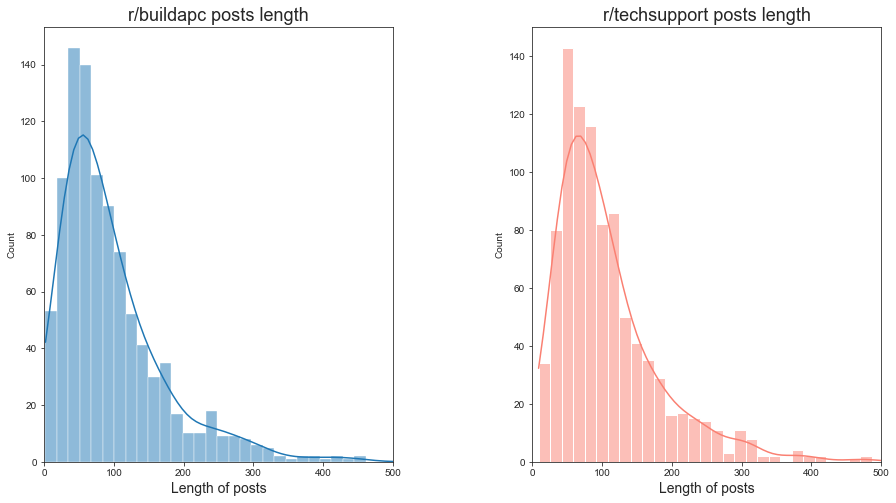

In [33]:
# plot histograms of text length for both subreddits

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,8), sharex = True)
plt.subplots_adjust(wspace = 0.4)

# for r/buildapc
sns.histplot(data = buildapc, x = 'text_len', ax = ax[0], kde = True)
ax[0].set_xlim(0,500)
ax[0].set_title('r/buildapc posts length', fontsize = 18)
ax[0].set_xlabel('Length of posts', fontsize = 14)

# for r/techsupport
sns.histplot(data = techsupport, x = 'text_len', ax = ax[1], kde = True, color = 'salmon')
ax[1].set_xlim(0,500)
ax[1].set_title('r/techsupport posts length', fontsize = 18)
ax[1].set_xlabel('Length of posts', fontsize = 14);

Generally, it can be seen that the length of the posts in both subreddits are generally similar as they are both right skewed and having a generally similar mean length of posts. 

### `CountVectorization`: Finding the top 50 words in both subreddits 

After removing links and certain rows above, I will be looking at the top 50 words again to observe if any further cleaning is required.

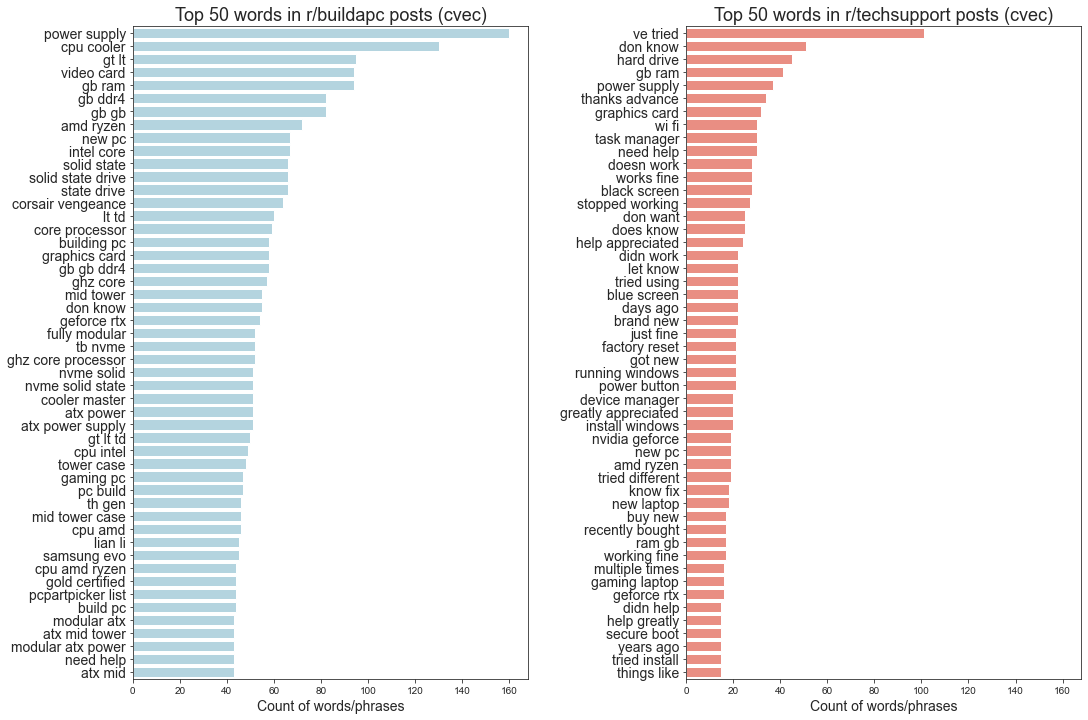

In [34]:
cvec_buildapc = cvec.fit_transform(buildapc['text_tokens'])
cvec_buildapc = pd.DataFrame(cvec_buildapc.toarray(), columns = cvec.get_feature_names())
buildapc_text_50 = cvec_buildapc.sum().sort_values(ascending = False).head(50)

cvec_techsupport = cvec.fit_transform(techsupport['text_tokens'])
cvec_techsupport = pd.DataFrame(cvec_techsupport.toarray(), columns = cvec.get_feature_names())
techsupport_text_50 = cvec_techsupport.sum().sort_values(ascending = False).head(50)

# plot bar charts of top 50 words in the text of posts of both subreddits
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (17,12), sharex = True)
plt.subplots_adjust(wspace = 0.4)

# bar chart for r/buildapc
sns.barplot(y = buildapc_text_50.index.values, x = buildapc_text_50, ax = ax[0], color='lightblue')
ax[0].set_title('Top 50 words in r/buildapc posts (cvec)', fontsize = 18)
ax[0].set_xlabel('Count of words/phrases', fontsize = 14)
plt.setp(ax[0].get_yticklabels(), fontsize = 14)

# bar chart for r/techsupport
sns.barplot(y = techsupport_text_50.index.values, x = techsupport_text_50, ax = ax[1], color = 'salmon')
ax[1].set_title('Top 50 words in r/techsupport posts (cvec)', fontsize = 18)
ax[1].set_xlabel('Count of words/phrases', fontsize = 14)
plt.setp(ax[1].get_yticklabels(), fontsize = 14);

### `TfidfVectorizer`: Finding the top 50 words in both subreddits 

After removing links and certain rows above, I will be looking at the top 50 words again to observe if any further cleaning is required.

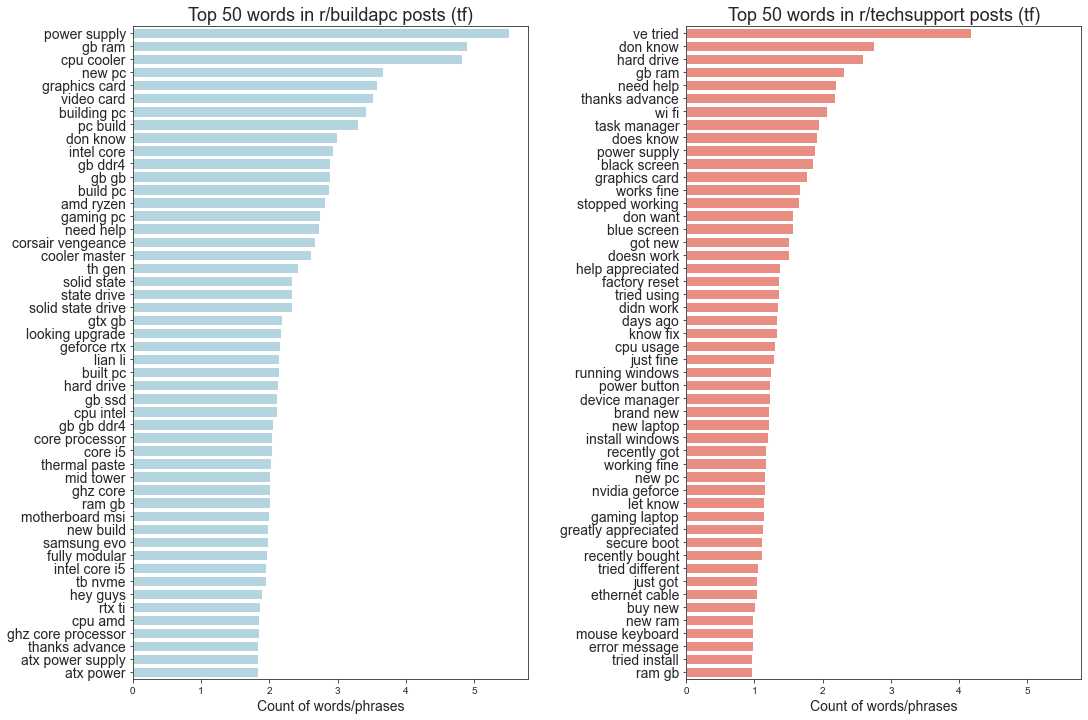

In [35]:
tf_buildapc = tf.fit_transform(buildapc['text_tokens'])
tf_buildapc = pd.DataFrame(tf_buildapc.toarray(), columns = tf.get_feature_names())
buildapc_text_50_tf = tf_buildapc.sum().sort_values(ascending = False).head(50)

tf_techsupport = tf.fit_transform(techsupport['text_tokens'])
tf_techsupport = pd.DataFrame(tf_techsupport.toarray(), columns = tf.get_feature_names())
techsupport_text_50_tf = tf_techsupport.sum().sort_values(ascending = False).head(50)

# plot bar charts of top 50 words in the text of posts of both subreddits
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (17,12), sharex = True)
plt.subplots_adjust(wspace = 0.4)

# bar chart for r/buildapc
sns.barplot(y = buildapc_text_50_tf.index.values, x = buildapc_text_50_tf, ax = ax[0], color='lightblue')
ax[0].set_title('Top 50 words in r/buildapc posts (tf)', fontsize = 18)
ax[0].set_xlabel('Count of words/phrases', fontsize = 14)
plt.setp(ax[0].get_yticklabels(), fontsize = 14)

# bar chart for r/techsupport
sns.barplot(y = techsupport_text_50_tf.index.values, x = techsupport_text_50_tf, ax = ax[1], color = 'salmon')
ax[1].set_title('Top 50 words in r/techsupport posts (tf)', fontsize = 18)
ax[1].set_xlabel('Count of words/phrases', fontsize = 14)
plt.setp(ax[1].get_yticklabels(), fontsize = 14);

The cleaning has help to remove the words related to the website links, the numbers appearing from the post with the system logs.

## Additional Stopwords

I will be using the default stops words in `CountVectorizer`'s `english` list and creating another list with more specific stop words relating to both subreddits. Words that are directly related to the subreddits' title should be removed to prevent data leakage which will artificially inflated the model's score. In addition, as seen from the EDA, in the r/techsupport subreddit, some of the top occurring words include *'thanks advance'*, *'help appreciated'*, *'greatly appreciated'* which are what the original posters will include as a form of courtesy to politely thank people in advanced who are going to offer advice or help. I will also be including these words into the list of stop words to remove these as they do not provide any input for the modeling process. 

I have explored using lemmatization and stemming to reduce these words into a base form like for *appreciate, appreciates, appreciated*, however the results aren't ideal and I will just include those words that are appear in the list of Top 50 words identified in the EDA portion in Notebook 2.

In [36]:
# default stop words list
stop_words_set = set(stopwords.words('english'))

# add additional stopwords
additional_stopwords = {'build', 'building', 'pc', ' computer', 'computers', 'tech', 'technology',\
                        'support', 'supporting', 'thanks', 'thank','appreciated', 'appreciate', 'appreciates',\
                       'help'}

stop_words_set = stop_words_set.union(additional_stopwords)


## EDA after including additional stop words

### `CountVectorization`: Finding the top 50 words in both subreddits 

After removing links and certain rows above, I will be looking at the top 50 words again to observe if any further cleaning is required.

In [37]:
# instantiate a new CountVectorizer model
cvec1 = CountVectorizer(stop_words = stop_words_set, ngram_range = (2,3))

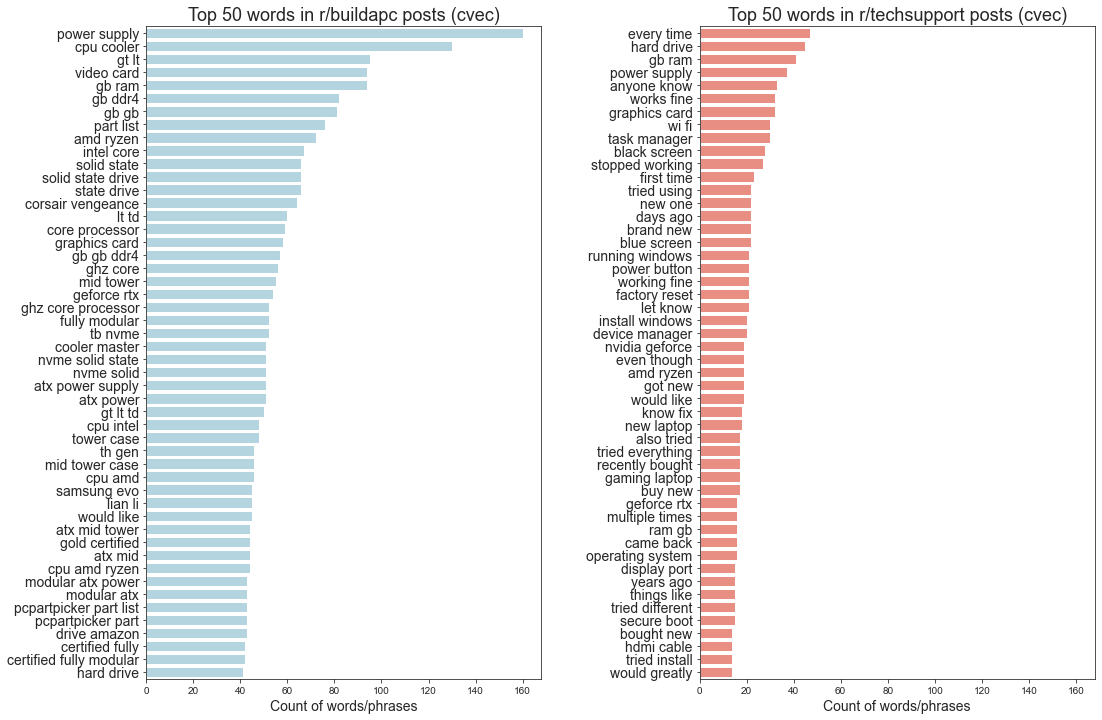

In [38]:
cvec_buildapc1 = cvec1.fit_transform(buildapc['text_tokens'])
cvec_buildapc1 = pd.DataFrame(cvec_buildapc1.toarray(), columns = cvec1.get_feature_names())
buildapc_text_50_1 = cvec_buildapc1.sum().sort_values(ascending = False).head(50)

cvec_techsupport1 = cvec1.fit_transform(techsupport['text_tokens'])
cvec_techsupport1 = pd.DataFrame(cvec_techsupport1.toarray(), columns = cvec1.get_feature_names())
techsupport_text_50_1 = cvec_techsupport1.sum().sort_values(ascending = False).head(50)

# plot bar charts of top 50 words in the text of posts of both subreddits
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (17,12), sharex = True)
plt.subplots_adjust(wspace = 0.4)

# bar chart for r/buildapc
sns.barplot(y = buildapc_text_50_1.index.values, x = buildapc_text_50_1, ax = ax[0], color='lightblue')
ax[0].set_title('Top 50 words in r/buildapc posts (cvec)', fontsize = 18)
ax[0].set_xlabel('Count of words/phrases', fontsize = 14)
plt.setp(ax[0].get_yticklabels(), fontsize = 14)

# bar chart for r/techsupport
sns.barplot(y = techsupport_text_50_1.index.values, x = techsupport_text_50_1, ax = ax[1], color = 'salmon')
ax[1].set_title('Top 50 words in r/techsupport posts (cvec)', fontsize = 18)
ax[1].set_xlabel('Count of words/phrases', fontsize = 14)
plt.setp(ax[1].get_yticklabels(), fontsize = 14);

#### Word Clouds

I will be plotting some word clouds to visually represent the words that are in the lists above.

In [39]:
# plot word clouds
wc_buildapc = WordCloud(max_words= 50, 
                        width = 1000, 
                        height = 800, 
                        background_color ='white',
                        colormap='icefire').generate_from_frequencies(buildapc_text_50_1) 


wc_techsupport = WordCloud(max_words= 50, 
                           width = 1000, 
                           height = 800, 
                           background_color ='white').generate_from_frequencies(techsupport_text_50_1)


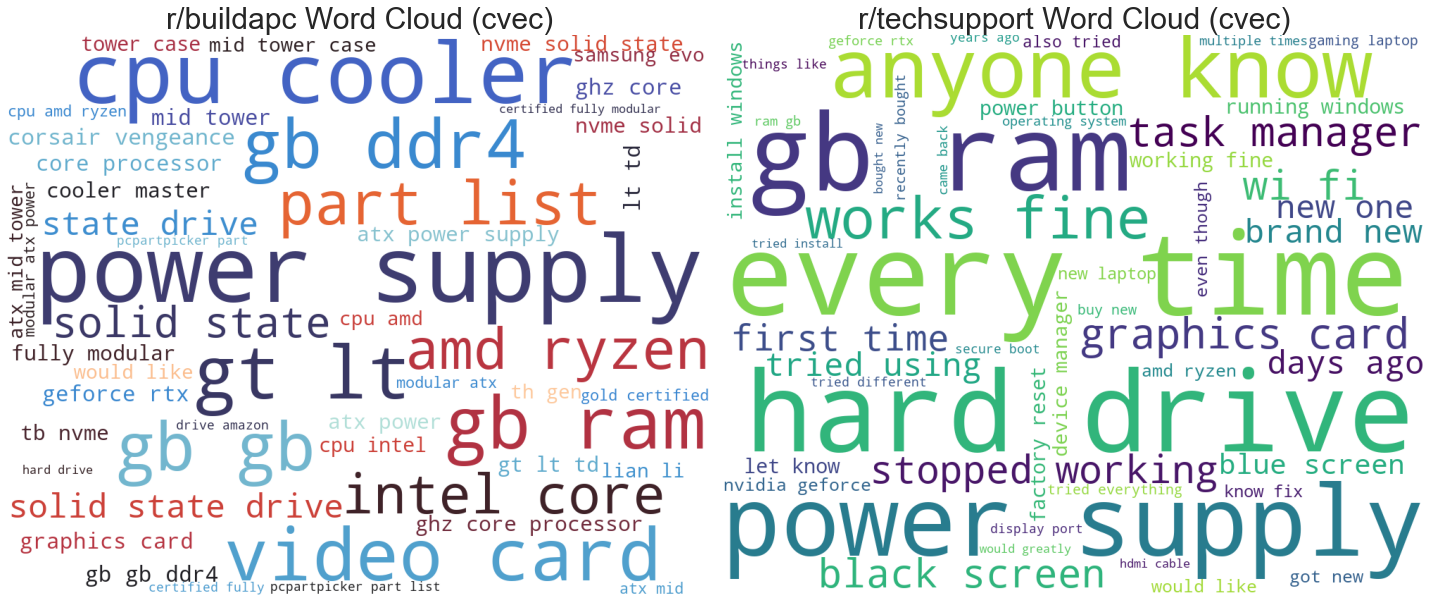

In [40]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20,13))
plt.subplots_adjust(wspace = 0.6)

ax[0].imshow(wc_buildapc)
ax[0].axis('off')
ax[0].set_title('r/buildapc Word Cloud (cvec)', fontsize = 30)

ax[1].imshow(wc_techsupport)
ax[1].axis('off')
ax[1].set_title('r/techsupport Word Cloud (cvec)', fontsize = 30)
plt.tight_layout();

#### To check for common words 

A Venn diagram shall be use to check for common words among the top 50 words in the posts for both subreddits. From the Venn diagram below, it can be seen that there are 7 common words which are printed below. 

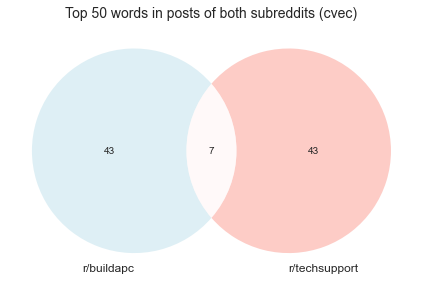

In [41]:
venn2([set(buildapc_text_50_1.index), set(techsupport_text_50_1.index)], set_labels = ('r/buildapc','r/techsupport'), set_colors = ('lightblue', 'salmon'))
plt.title('Top 50 words in posts of both subreddits (cvec)', fontsize=14)
plt.tight_layout()

In [42]:
# print the common words between the two subreddits
print([x for x in buildapc_text_50_1.index if x in techsupport_text_50_1.index])

['power supply', 'gb ram', 'amd ryzen', 'graphics card', 'geforce rtx', 'would like', 'hard drive']


### `TfidfVectorizer`: Finding the top 50 words in both subreddits 

After removing links and certain rows above, I will be looking at the top 50 words again to observe if any further cleaning is required.

In [43]:
# instantiate a new TfidfVectorizer model
tf1 = TfidfVectorizer(stop_words = stop_words_set, ngram_range = (2,3))

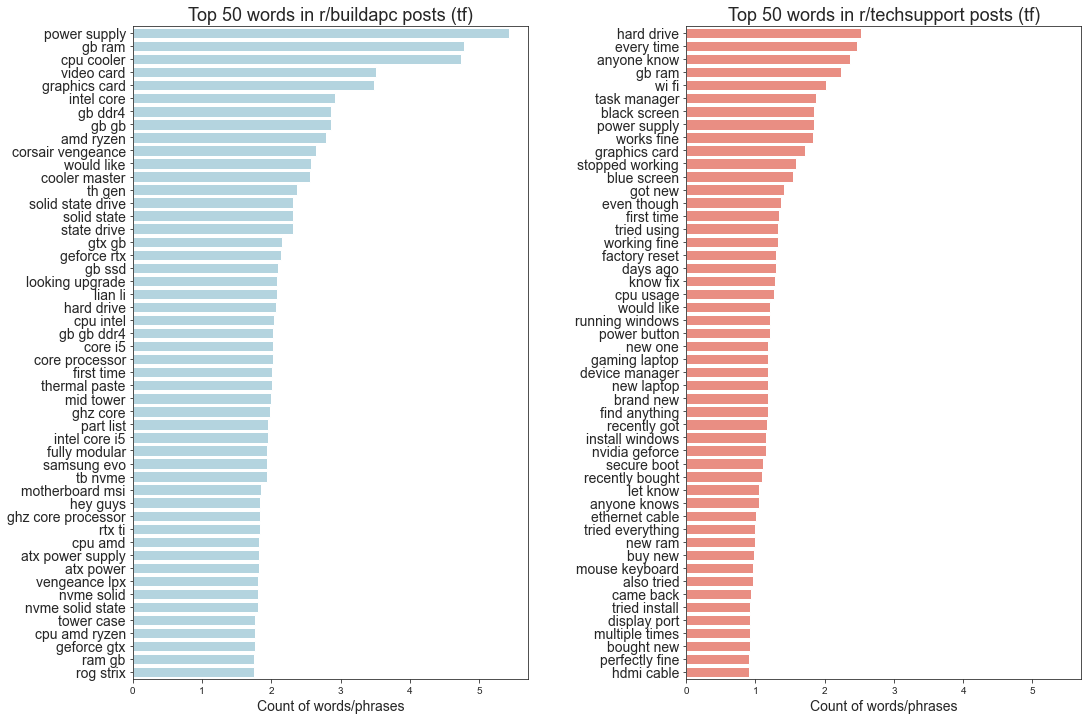

In [44]:
tf_buildapc1 = tf1.fit_transform(buildapc['text_tokens'])
tf_buildapc1 = pd.DataFrame(tf_buildapc1.toarray(), columns = tf1.get_feature_names())
buildapc_text_50_tf1 = tf_buildapc1.sum().sort_values(ascending = False).head(50)

tf_techsupport1 = tf1.fit_transform(techsupport['text_tokens'])
tf_techsupport1 = pd.DataFrame(tf_techsupport1.toarray(), columns = tf1.get_feature_names())
techsupport_text_50_tf1 = tf_techsupport1.sum().sort_values(ascending = False).head(50)

# plot bar charts of top 50 words in the text of posts of both subreddits
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (17,12), sharex = True)
plt.subplots_adjust(wspace = 0.4)

# bar chart for r/buildapc
sns.barplot(y = buildapc_text_50_tf1.index.values, x = buildapc_text_50_tf1, ax = ax[0], color='lightblue')
ax[0].set_title('Top 50 words in r/buildapc posts (tf)', fontsize = 18)
ax[0].set_xlabel('Count of words/phrases', fontsize = 14)
plt.setp(ax[0].get_yticklabels(), fontsize = 14)

# bar chart for r/techsupport
sns.barplot(y = techsupport_text_50_tf1.index.values, x = techsupport_text_50_tf1, ax = ax[1], color = 'salmon')
ax[1].set_title('Top 50 words in r/techsupport posts (tf)', fontsize = 18)
ax[1].set_xlabel('Count of words/phrases', fontsize = 14)
plt.setp(ax[1].get_yticklabels(), fontsize = 14);

#### Word Clouds

I will be plotting some word clouds to visually represent the words that are in the lists above.

In [45]:
# plot word clouds
wc_buildapc_tf = WordCloud(max_words= 50, 
                        width = 1000, 
                        height = 800, 
                        background_color = 'white',
                        colormap='icefire').generate_from_frequencies(buildapc_text_50_tf1) 


wc_techsupport_tf = WordCloud(max_words= 50, 
                           width = 1000, 
                           height = 800, 
                           background_color ='white').generate_from_frequencies(techsupport_text_50_tf1)


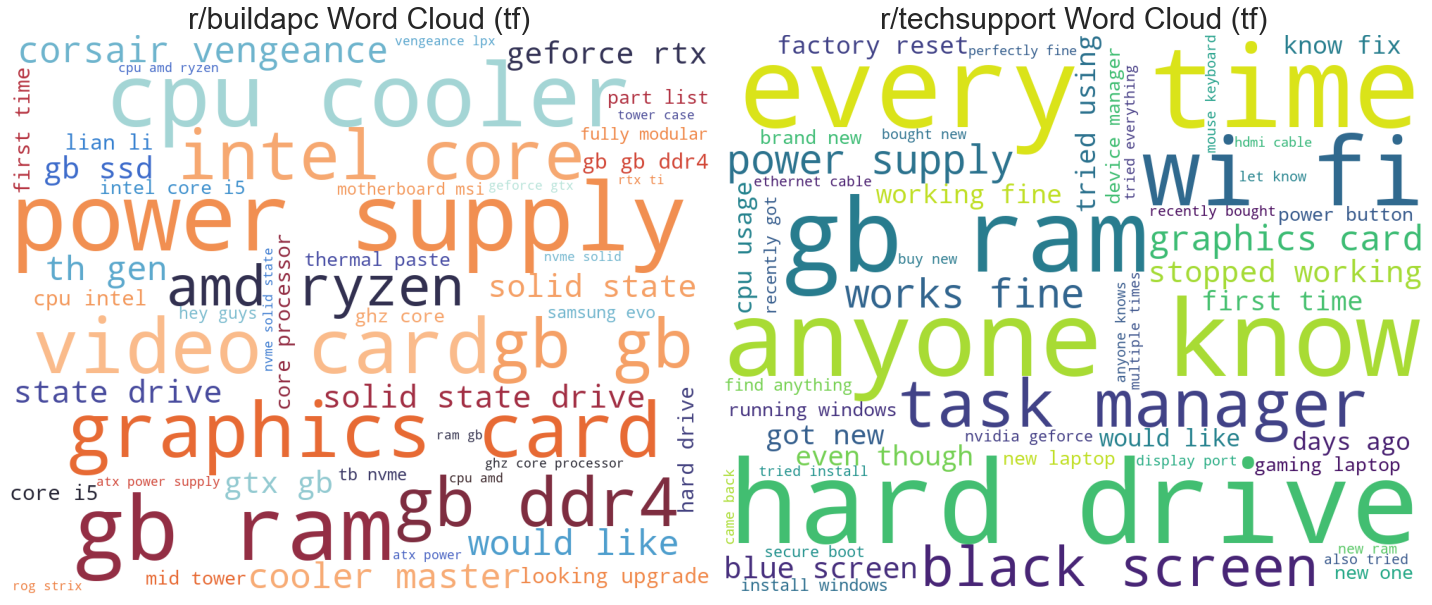

In [46]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20,13))
plt.subplots_adjust(wspace = 0.6)

ax[0].imshow(wc_buildapc_tf)
ax[0].axis('off')
ax[0].set_title('r/buildapc Word Cloud (tf)', fontsize = 30)

ax[1].imshow(wc_techsupport_tf)
ax[1].axis('off')
ax[1].set_title('r/techsupport Word Cloud (tf)', fontsize = 30)
plt.tight_layout();

#### To check for common words 

A Venn diagram shall be use to check for common words among the top 50 words in the posts for both subreddits. From the Venn diagram below, it can be seen that there are 6 common words which are printed below. 

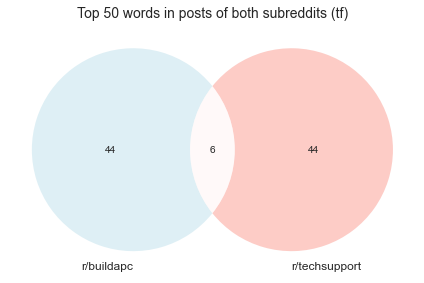

In [47]:
venn2([set(buildapc_text_50_tf1.index), set(techsupport_text_50_tf1.index)], set_labels = ('r/buildapc','r/techsupport'), set_colors = ('lightblue', 'salmon'))
plt.title('Top 50 words in posts of both subreddits (tf)', fontsize = 14)
plt.tight_layout()

In [48]:
# print the common words between the two subreddits
print([x for x in buildapc_text_50_tf1.index if x in techsupport_text_50_tf1.index])

['power supply', 'gb ram', 'graphics card', 'would like', 'hard drive', 'first time']


## Findings and Next Step
***



From the EDA process above, it can be seen that the raw data in the text of the posts for both subreddits contain a lot of noise in the form of website links and system logs dates. The data was cleaned accordingly and it has provided a clearer understanding of the key words in each subreddits and therefore the data will be a better predictor for the subreddit class for modeling to be done in the next notebook. 

In [52]:
buildapc

,subreddit,title,selftext,text,text_tokens,text_len
0,buildapc,3080 or 6900xt?,So I'm gonna be building a gaming PC for 4k ga...,3080 or 6900xt? So I'm gonna be building a gam...,or xt So gonna be building gaming PC for gamin...,42
1,buildapc,"Upgrading to a 1440p144Hz setup, would like so...",**What is your intended use for this build? Th...,"Upgrading to a 1440p144Hz setup, would like so...",Upgrading to p144Hz setup would like some fina...,606
2,buildapc,Help fine tune my build before it's final.,My 2500k/980 build is on it's knees and about ...,Help fine tune my build before it's final. My ...,Help fine tune my build before it final My bui...,424
3,buildapc,Need help picking out a KVM or other solution ...,"As the tittle says, im looking for a KVM switc...",Need help picking out a KVM or other solution ...,Need help picking out KVM or other solution to...,85
4,buildapc,Ryzen 5 3600 + GT 710 or Ryzen 3 3200G,Hello! So unfortunately my old GPU died last w...,Ryzen 5 3600 + GT 710 or Ryzen 3 3200G Hello! ...,Ryzen GT or Ryzen Hello So unfortunately my ol...,52
...,...,...,...,...,...,...
971,buildapc,Is ARCTIC Liquid Freezer II 280 good enough fo...,,Is ARCTIC Liquid Freezer II 280 good enough fo...,Is ARCTIC Liquid Freezer II good enough for i7...,11
972,buildapc,Hey guys! I have a 500W 80+ Bronze PSU and a R...,,Hey guys! I have a 500W 80+ Bronze PSU and a R...,Hey guys have Bronze PSU and Ryzen Will be abl...,18
973,buildapc,"Zalman z7 Neo, rgb controller, The cable says ...",,"Zalman z7 Neo, rgb controller, The cable says ...",Zalman z7 Neo rgb controller The cable says PO...,34
974,buildapc,If i already have a graphics card intergrated ...,,If i already have a graphics card intergrated ...,If already have graphics card intergrated in m...,15


## Export Data

In [49]:
# creating a new dataframe with only the subreddit and lemmatized words
buildapc_processed = buildapc[['subreddit', 'text_tokens']]
buildapc_processed.head()

,subreddit,text_tokens
0,buildapc,or xt So gonna be building gaming PC for gamin...
1,buildapc,Upgrading to p144Hz setup would like some fina...
2,buildapc,Help fine tune my build before it final My bui...
3,buildapc,Need help picking out KVM or other solution to...
4,buildapc,Ryzen GT or Ryzen Hello So unfortunately my ol...


In [50]:
# creating a new dataframe with only the subreddit and lemmatized words
techsupport_processed = techsupport[['subreddit', 'text_tokens']]
techsupport_processed.head()

,subreddit,text_tokens
0,techsupport,Win dwm exe is using way too much vram have be...
1,techsupport,Toshiba Qosmio X70B10T graphics card not detec...
2,techsupport,How to find original MD5 Hash Hello am trying ...
3,techsupport,Is it worth upgrading to Windows for mostly ga...
4,techsupport,Deleted google tv remote can control tv was ha...


In [51]:
buildapc_processed.to_csv('../datasets/buildapc_processed.csv', index = False)
techsupport_processed.to_csv('../datasets/techsupport_processed.csv', index = False)